In [9]:

import numpy as np
from numpy import random
import gym
from gym import spaces
import torch
import torch.nn as nn
import random
from collections import deque
from matplotlib import pyplot as plt
import torch.optim as optim

In [2]:
def init_q_table(n_states,n_actions):
    a=np.zeros(n_states,n_actions)
    return a
    



In [12]:
def q_update(Q,s,a,r,s_next,alpha,gamma):
    a2=np.argmax(Q[s_next])
    Q[s,a]=Q[s,a]+alpha(r+gamma*(Q[s_next,a2]-Q[s,a]))

In [3]:
# Define GridWorld Environment (4x4)
class GridWorld:
    def __init__(self, size=4):
        self.size = size
        self.terminal_states = [0, size*size - 1]  # Top-left and bottom-right
        self.reset()

    def reset(self):
        self.state = 1  # Start from a non-terminal state (e.g., index 1)
        return self.state

    def step(self, action):
        row, col = divmod(self.state, self.size)

        if action == 0 and row > 0:  # up
            row -= 1
        elif action == 1 and col < self.size - 1:  # right
            col += 1
        elif action == 2 and row < self.size - 1:  # down
            row += 1
        elif action == 3 and col > 0:  # left
            col -= 1

        next_state = row * self.size + col
        reward = 1 if next_state in self.terminal_states else -0.01
        done = next_state in self.terminal_states

        self.state = next_state
        return next_state, reward, done



In [4]:
# Epsilon-greedy action selection
def select_action(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(Q.shape[1])
    else:
        return np.argmax(Q[state])


In [5]:
# Q-learning training loop
def train_agent(epsilon):
    env = GridWorld(size=4)
    Q = np.zeros((16, 4))  # 16 states, 4 actions
    alpha = 0.1
    gamma = 0.99
    episodes = 500
    reward_log = []

    for ep in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = select_action(Q, state, epsilon)
            next_state, reward, done = env.step(action)

            max_q_next = np.max(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * max_q_next - Q[state, action])

            state = next_state
            total_reward += reward

        reward_log.append(total_reward)

    return reward_log


In [6]:
# Moving average function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')


In [7]:
# Train agents with different epsilons
rewards_eps_01 = train_agent(epsilon=0.1)
rewards_eps_02 = train_agent(epsilon=0.2)


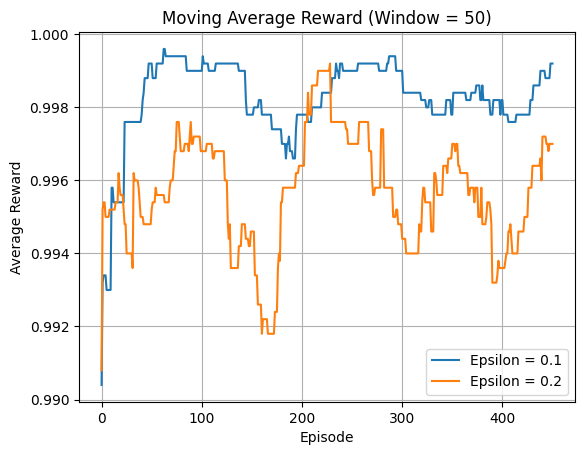

In [10]:
# Plot moving averages
avg_01 = moving_average(rewards_eps_01, 50)
avg_02 = moving_average(rewards_eps_02, 50)

plt.plot(avg_01, label="Epsilon = 0.1")
plt.plot(avg_02, label="Epsilon = 0.2")
plt.title("Moving Average Reward (Window = 50)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()


In [13]:


class DQNPolicy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNPolicy, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class DQNTarget(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNTarget, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [14]:


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        #Store a transition in the buffer.
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #Sample a batch of transitions.
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


In [27]:
EPISODES = 500
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
GAMMA = 0.99
LR = 0.001
BATCH_SIZE = 64
MEM_SIZE = 10000
TARGET_UPDATE = 10

# --- Q-network ---
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


In [28]:
# --- ε-greedy policy ---
def select_action(state, policy_net, epsilon, action_dim):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        with torch.no_grad():
            return torch.argmax(policy_net(torch.tensor(state, dtype=torch.float32))).item()


In [29]:
# --- Main training loop ---
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
replay_buffer = ReplayBuffer(MEM_SIZE)

epsilon = EPS_START
reward_history = []

for episode in range(EPISODES):
    state = env.reset()
    if isinstance(state, tuple):  # For newer gym
        state = state[0]

    total_reward = 0
    done = False

    while not done:
        action = select_action(state, policy_net, epsilon, action_dim)
        result = env.step(action)

    
        if len(result) == 5:
            next_state, reward, terminated, truncated, _ = result
            done = terminated or truncated
        else:
            next_state, reward, done, _ = result

        replay_buffer.push((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # Training step
        if len(replay_buffer) >= BATCH_SIZE:
            batch = replay_buffer.sample(BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.tensor(states, dtype=torch.float32)
            actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
            next_states = torch.tensor(next_states, dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

            q_values = policy_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
            target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    epsilon = max(EPS_END, epsilon * EPS_DECAY)
    reward_history.append(total_reward)

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode + 1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")



AttributeError: module 'numpy' has no attribute 'bool8'

In [ ]:
def moving_average(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.plot(moving_average(reward_history))
plt.title("Moving Average Reward (window=50)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid()
plt.show()